In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.euler_backward as eb
import cbmos.cell as cl

In [2]:
plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
          'legend.fontsize': 'xx-large',
         'font.size': 11,
          'font.family': 'serif',
          "mathtext.fontset": "dejavuserif",
         'axes.titlepad': 12,
        'axes.labelpad': 12}
plt.rcParams.update(params)

In [3]:
# Simulation parameters
s = 1.0    # rest length
tf = 1.0  # final time
rA = 1.5   # maximum interaction distance

seed=17

params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': muR*ratio, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls = 1.95
params_gls = {'mu': mu_gls, 'a': 7.51}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}

In [4]:
force_names = ['cubic', 'pw. quad.', 'GLS']
solver_names = ['EF', 'EB']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}
linestyles = {'cubic': '-', 'pw. quad.': '--', 'GLS': '-.'}

In [5]:
models_ef = {'pw. quad.': cbmos.CBMModel(ff.PiecewisePolynomial(), ef.solve_ivp, 1), 
             'cubic': cbmos.CBMModel(ff.Cubic(), ef.solve_ivp, 1),
             'GLS': cbmos.CBMModel(ff.Gls(), ef.solve_ivp, 1)}
models_eb = {'pw. quad.': cbmos.CBMModel(ff.PiecewisePolynomial(), eb.solve_ivp, 1), 
             'cubic': cbmos.CBMModel(ff.Cubic(), eb.solve_ivp, 1),
             'GLS': cbmos.CBMModel(ff.Gls(), eb.solve_ivp, 1)}
model_dicts = {'EF': models_ef, 'EB': models_eb}

In [6]:
# Initial condition
cell_list = [cl.Cell(0, [0], proliferating=False), cl.Cell(1, [0.3], proliferating=False)]

In [7]:
t_data_ref = np.linspace(0, tf, 10000+1)


In [8]:
len(t_data_ref)

10001

In [9]:
t_data_ref[-1]

1.0

In [10]:
dt = 1e-4
t_data_ref = np.arange(0, tf, dt)
#t_data_ref = np.linspace(0, tf, 10000+1)

#t_data_ref=[0,tf]
ref_sol_dicts = {}
for solver in solver_names:
    models = model_dicts[solver]
    ref_sols = {}
    for force in force_names: 
        #params_solver = {'EF':{'dt': 0.0001}, 'EB': {'dt': 0.0001, 'jacobian': models[force].jacobian}}
        params_solver = {'EF':{'dt': dt}, 'EB': {'dt': dt, 'eps': dt, 'tol': dt, 'atol': dt}}
        (t_data, history) = models[force].simulate(cell_list, t_data_ref, params[force], params_solver[solver], seed=seed)
        ref_sols[force] = (t_data, np.array([np.abs(clt[1].position - clt[0].position) for clt in history]))
    ref_sol_dicts[solver] = ref_sols

In [11]:
len(ref_sol_dicts['EB'][force])

2

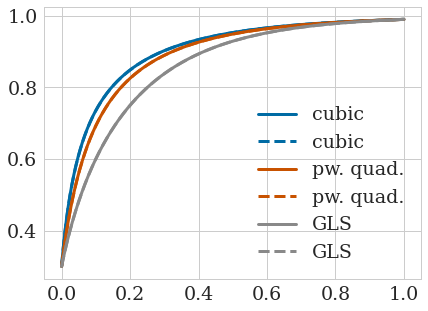

In [12]:
# plot the reference solution
for force in force_names:
    plt.plot(ref_sol_dicts['EF'][force][0], ref_sol_dicts['EF'][force][1], label=force, color=colors[force])
    plt.plot(ref_sol_dicts['EB'][force][0], ref_sol_dicts['EB'][force][1], label=force, linestyle='--', color=colors[force])
plt.legend()

In [13]:
dt_values = [0.001*1.25**n for n in range(0, 28)]

In [14]:
sol_dicts = {}

In [15]:
n = 15 
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(tf/dt) + 1
    print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,tf,dt)
    
    for force in force_names:
        av_time = 0
        for j in np.arange(n):
            start = time.time()
            (t, history) = model_dicts['EF'][force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)
            exec_time = time.time() - start
            av_time = av_time + exec_time
        av_time = av_time / n
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        t_ref = ref_sol_dicts['EF'][force][0]
        inter = np.interp(t_ref, t, np.squeeze(y))
        ref = np.squeeze(ref_sol_dicts['EF'][force][1])
        sol[force].append((np.linalg.norm(inter-ref)/np.linalg.norm(ref), av_time))
sol_dicts['EF'] = sol

[1001, 0.001]
[801, 0.00125]
[641, 0.0015625]
[513, 0.001953125]
[410, 0.00244140625]
[328, 0.0030517578125]
[263, 0.003814697265625]
[210, 0.00476837158203125]
[168, 0.0059604644775390625]
[135, 0.007450580596923828]
[108, 0.009313225746154785]
[86, 0.011641532182693481]
[69, 0.014551915228366852]
[55, 0.018189894035458565]
[44, 0.022737367544323206]
[36, 0.028421709430404007]
[29, 0.03552713678800501]
[23, 0.04440892098500626]
[19, 0.05551115123125783]
[15, 0.06938893903907228]
[12, 0.08673617379884035]
[10, 0.10842021724855044]
[8, 0.13552527156068805]
[6, 0.16940658945086007]
[5, 0.21175823681357508]
[4, 0.2646977960169689]
[4, 0.3308722450212111]
[3, 0.41359030627651383]


In [16]:
np.array(sol_dicts['EF']['cubic'])[:,0]

array([7.99261521e-04, 1.02265776e-03, 1.30278325e-03, 1.65433469e-03,
       2.09599250e-03, 2.65161015e-03, 3.35188401e-03, 4.23657361e-03,
       5.35792491e-03, 6.78565030e-03, 8.61478698e-03, 1.09794752e-02,
       1.40780857e-02, 1.82205917e-02, 2.39282671e-02, 3.21363692e-02,
       4.46048775e-02, 6.47795810e-02, 9.98753954e-02, 1.67958632e-01,
       3.35418977e-01, 6.50456170e-01, 9.61892139e-01, 1.34378379e+00,
       1.80764716e+00, 2.36479481e+00, 3.02376737e+00, 3.78548991e+00])

In [17]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EF'][force])[:, 0] > 0.01)[0][0]]])

['cubic', 0.011641532182693481]
['pw. quad.', 0.014551915228366852]
['GLS', 0.018189894035458565]


In [18]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EF'][force])[:, 0] > 0.1)[0][0]]])

['cubic', 0.06938893903907228]
['pw. quad.', 0.08673617379884035]
['GLS', 0.13552527156068805]


In [19]:
n = 5
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(tf/dt) + 1
    print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,tf,dt)
    
    for force in force_names:
        av_time = 0
        for j in np.arange(n):
            start = time.time()
            (t, history) = model_dicts['EB'][force].simulate(cell_list, t_data, params[force], {'dt': dt, 'eps': dt, 'tol': dt, 'atol': dt}, seed=seed)
            exec_time = time.time() - start
            av_time = av_time + exec_time
        av_time = av_time / n
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        t_ref = ref_sol_dicts['EB'][force][0]
        inter = np.interp(t_ref, t, np.squeeze(y))
        ref = np.squeeze(ref_sol_dicts['EB'][force][1])
        sol[force].append((np.linalg.norm(inter-ref)/np.linalg.norm(ref), av_time))
sol_dicts['EB'] = sol

[1001, 0.001]
[801, 0.00125]
[641, 0.0015625]
[513, 0.001953125]
[410, 0.00244140625]
[328, 0.0030517578125]
[263, 0.003814697265625]
[210, 0.00476837158203125]
[168, 0.0059604644775390625]
[135, 0.007450580596923828]
[108, 0.009313225746154785]
[86, 0.011641532182693481]
[69, 0.014551915228366852]
[55, 0.018189894035458565]
[44, 0.022737367544323206]
[36, 0.028421709430404007]
[29, 0.03552713678800501]
[23, 0.04440892098500626]
[19, 0.05551115123125783]
[15, 0.06938893903907228]
[12, 0.08673617379884035]
[10, 0.10842021724855044]
[8, 0.13552527156068805]
[6, 0.16940658945086007]
[5, 0.21175823681357508]
[4, 0.2646977960169689]
[4, 0.3308722450212111]
[3, 0.41359030627651383]


In [20]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EB'][force])[:, 0] > 0.01)[0][0]]])

['cubic', 0.014551915228366852]
['pw. quad.', 0.018189894035458565]
['GLS', 0.018189894035458565]


In [21]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EB'][force])[:, 0] > 0.1)[0][0]]])

['cubic', 0.16940658945086007]
['pw. quad.', 0.16940658945086007]
['GLS', 0.21175823681357508]


In [22]:
dt_values

[0.001,
 0.00125,
 0.0015625,
 0.001953125,
 0.00244140625,
 0.0030517578125,
 0.003814697265625,
 0.00476837158203125,
 0.0059604644775390625,
 0.007450580596923828,
 0.009313225746154785,
 0.011641532182693481,
 0.014551915228366852,
 0.018189894035458565,
 0.022737367544323206,
 0.028421709430404007,
 0.03552713678800501,
 0.04440892098500626,
 0.05551115123125783,
 0.06938893903907228,
 0.08673617379884035,
 0.10842021724855044,
 0.13552527156068805,
 0.16940658945086007,
 0.21175823681357508,
 0.2646977960169689,
 0.3308722450212111,
 0.41359030627651383]

In [23]:
sol_dicts['EF']['GLS']

[(0.0005190345280711697, 0.08465091387430827),
 (0.0006635481427560132, 0.06846418380737304),
 (0.0008443882851709439, 0.05259888966878255),
 (0.0010707726427683717, 0.04138439496358236),
 (0.001354278564468997, 0.0342007319132487),
 (0.0017094576328008247, 0.02725850741068522),
 (0.0021547379829666073, 0.022234376271565756),
 (0.0027133142459525488, 0.017166630427042643),
 (0.003414790506202332, 0.014031521479288737),
 (0.004296919586212135, 0.011602671941121419),
 (0.00540780415310283, 0.012642510732014974),
 (0.0068096579819157945, 0.013591639200846354),
 (0.008584480494798968, 0.010175577799479167),
 (0.010838992691476382, 0.006630929311116537),
 (0.013718705363383932, 0.006066052118937174),
 (0.017424514437722482, 0.0038444995880126953),
 (0.02223472871607874, 0.0033864498138427733),
 (0.028559850071011958, 0.003117863337198893),
 (0.03701967239187759, 0.0036440372467041017),
 (0.04855964814203157, 0.001655912399291992),
 (0.06466741615873167, 0.0011044661204020181),
 (0.087670677

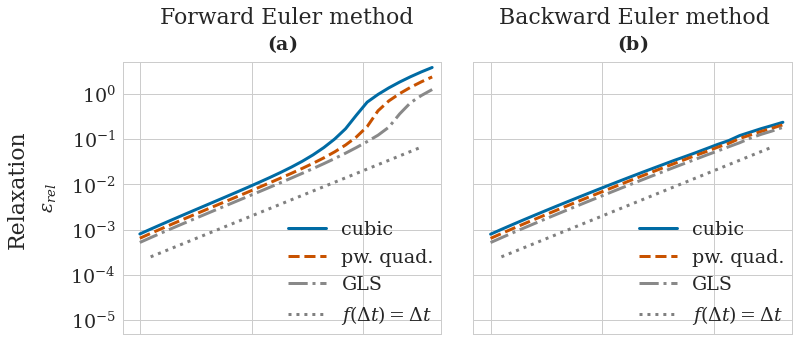

In [24]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5), sharey=True, gridspec_kw={'wspace': 0.1})

# ax1
for force in force_names: 
    ax1.loglog(dt_values, np.array(sol_dicts['EF'][force])[:,0], label=force, color=colors[force], linestyle=linestyles[force])
    #plt.loglog(dt_values, np.array(sol_dicts['EF'][force])[:,1], label=force+' y')
ax1.loglog(dt_values[1:-1], np.array(dt_values[1:-1])*0.2, ':', label='$f(\Delta t)= \Delta t$', color='grey')
ax1.legend(loc='lower right', borderaxespad=0.)
#plt.legend()
#ax1.set(xlabel='$\Delta t$')
ax1.set_title(r'$\bf{(a)}$')
ax1.set(ylabel='$\epsilon_{rel}$')
ax1.set_xlim([7*1e-4, 5*1e-1])
ax1.set_ylim([5*1e-6, 5*1e-0])
ax1.set_xticklabels([])
#ax1.set_ylim([5*1e-8, 5*1e-0])
ax1.text(0.0015, 35, 'Forward Euler method', fontsize=22)
ax1.text(0.000065, 0.0005, 'Relaxation', fontsize=22, rotation='vertical')


#ax2
for force in force_names: 
    ax2.loglog(dt_values, np.array(sol_dicts['EB'][force])[:,0], label=force, color=colors[force], linestyle=linestyles[force])
    #plt.loglog(dt_values, np.array(sol_dicts[current_solver][force])[:,1], label=force+' y')
ax2.loglog(dt_values[1:-1], np.array(dt_values[1:-1])*0.2, ':', label='$f(\Delta t)= \Delta t$', color='grey')
ax2.legend(loc='lower right',borderaxespad=0.)
#ax2.set(xlabel='$\Delta t$')
ax2.set_xlim([7*1e-4, 5*1e-1])
ax2.set_title(r'$\bf{(b)}$')
ax2.set_xticklabels([])

ax2.text(0.0012, 35, 'Backward Euler method', fontsize=22)
plt.savefig('convergence_study_EB.pdf', bbox_inches='tight')

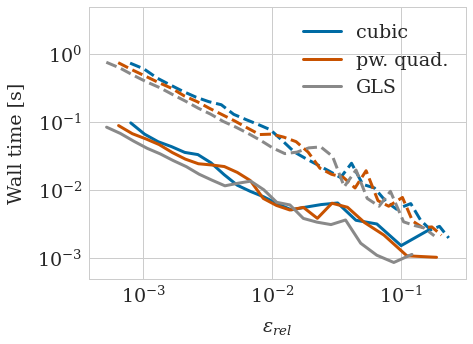

In [25]:
end_index = {'cubic': -8, 'pw. quad.': -6, 'GLS': -5}

for force in force_names:
    plt.loglog(np.array(sol_dicts['EF'][force])[:end_index[force],0], np.array(sol_dicts['EF'][force])[:end_index[force],1], label=force, color=colors[force])
    plt.loglog(np.array(sol_dicts['EB'][force])[:,0], np.array(sol_dicts['EB'][force])[:,1], linestyle='--', color=colors[force])

plt.xlabel('$\epsilon_{rel}$')    
plt.ylabel('Wall time [s]')
plt.ylim([5*1e-4, 5*1e-0])
plt.legend()
plt.savefig('exec_time_EB.pdf', bbox_inches='tight')